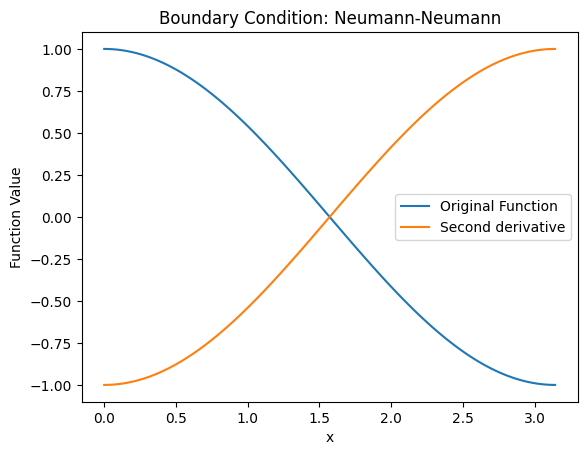

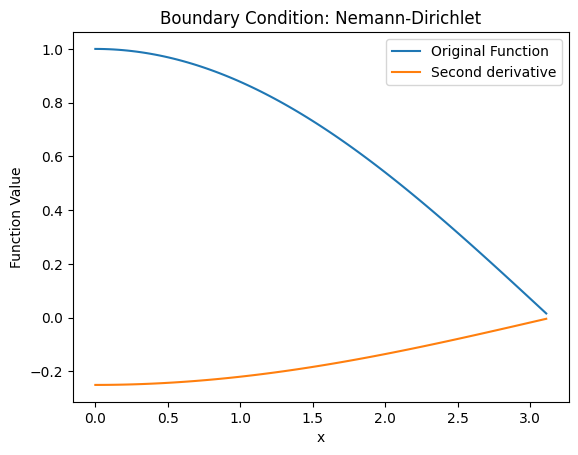

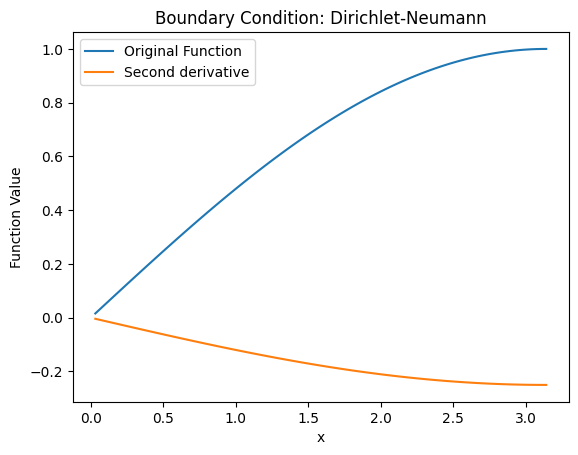

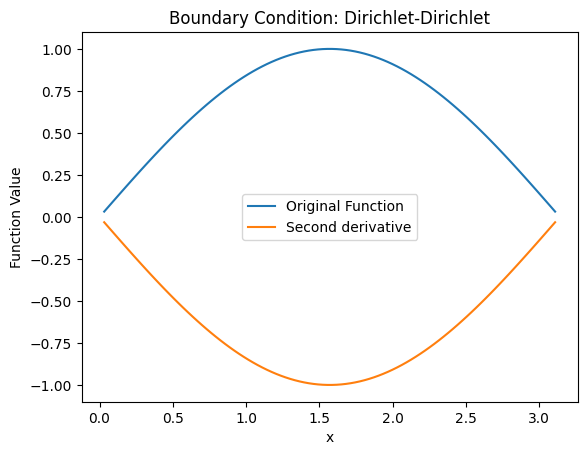

In [12]:
import numpy as np
import scipy
import matplotlib.pyplot as plt


DCT1 = 1    # WSWS
DCT2 = 2    # HSHS
DCT3 = 3    # WSWA
DCT4 = 4    # HSHA
DST1 = 5    # WAWA
DST2 = 6    # HAHA
DST3 = 7    # WAWS
DST4 = 8    # HAHS
DFT1 = 9    # PERIODIC

NN       = DCT1
ND       = DCT3
DN       = DST3
DD       = DST1
PERIODIC = DFT1


DCT1 = 1    # WSWS
DCT2 = 2    # HSHS
DCT3 = 3    # WSWA
DCT4 = 4    # HSHA
DST1 = 5    # WAWA
DST2 = 6    # HAHA
DST3 = 7    # WAWS
DST4 = 8    # HAHS
DFT1 = 9    # PERIODIC

#Note:
def computeX(L0, L1, N):
    L  = L1 - L0
    dx = L/(N - 1)
    xx = np.arange(0, N) * dx + L0
    return xx, dx

# Return representative sample and boundary indices for psi depending on boundary conditions bc_ind
def selectBC(psi, bc_ind):
    Nx = len(psi)

    # define which transforms to use
    if bc_ind == NN:

        # Neumann-Neumann / WSWS
        T1 = DCT1

        # set indices for representative sample
        ind1 = 0
        ind2 = Nx

    elif bc_ind == ND:

        # Neumann-Dirichlet / WSWA
        T1 = DCT3

        # set indices for representative sample
        ind1 = 0
        ind2 = Nx - 1

    elif bc_ind == DN:

        # Dirichlet-Neumann / WAWS
        T1 = DST3

        # set indices for representative sample
        ind1 = 1
        ind2 = Nx

    elif bc_ind == DD:

        # Dirichlet-Dirichlet / WAWA
        T1 = DST1

        # set indices for representative sample
        ind1 = 1
        ind2 = Nx - 1

    elif bc_ind == PERIODIC:

        # Periodic
        T1 = DFT1

        # set indices for representative sample
        ind1 = 0
        ind2 = Nx - 1

    else:
        raise ValueError("Invalid bc_ind")


    # assign initial condition for p, just selecting representative sample
    p = psi[ind1 : ind2]
    return p, ind1, ind2

# Restore full function from representative sample depending on boundary conditions
def restoreBC(psi, bc_ind):
    #Nx = len(psi)

    # define which transforms to use
    if bc_ind == NN:

        # Neumann-Neumann / WSWS
        #T1 = DCT1

        # set indices for representative sample
        #ind1 = 0
        #ind2 = Nx

        return psi

    elif bc_ind == ND:

        # Neumann-Dirichlet / WSWA
        #T1 = DCT3

        # set indices for representative sample
        #ind1 = 0
        #ind2 = Nx - 1

        # mode = "constant" pads with zeros by default
        psi = np.pad(psi, (0, 1), mode="constant")

    elif bc_ind == DN:

        # Dirichlet-Neumann / WAWS
        #T1 = DST3

        # set indices for representative sample
        #ind1 = 1
        #ind2 = Nx

        # mode = "constant" pads with zeros by default
        psi = np.pad(psi, (1, 0), mode="constant")

    elif bc_ind == DD:

        # Dirichlet-Dirichlet / WAWA
        #T1 = DST1

        # set indices for representative sample
        #ind1 = 1
        #ind2 = Nx - 1
        psi = np.pad(psi, (1, 1), mode="constant")

    elif bc_ind == PERIODIC:

        # Periodic
        #T1 = DFT1

        # set indices for representative sample
        #ind1 = 0
        #ind2 = Nx - 1

        # mode = "wrap" fills with the values from the other side of the array
        psi = np.pad(psi, (0, 1), mode="wrap")

    return psi

def computeK(p, dx, T1):
    N = len(p)

    #WSWS
    if T1 == DCT1:
        M = 2 * ( N - 1 )
        n = np.arange(0, int(M/2) + 1)
        k = 2 * np.pi / ( M * dx ) * n
    #HSHS
    elif T1 == DCT2:
        M = 2 * N
        n = np.arange(0, int(M/2)    )
        k = 2 * np.pi / ( M * dx ) * n
    #WAWA
    elif T1 == DST1:
        M = 2 * ( N + 1 )
        n = np.arange(1, int(M/2)    )
        k = 2 * np.pi / ( M * dx ) * n
    #HAHA
    elif T1 == DST2:
        M = 2 * N
        n = np.arange(1, int(M/2) + 1)
        k = 2 * np.pi / ( M * dx ) * n
    #WSWA or HSHA or WAWS or HAHS
    elif T1 == DCT3 or T1 == DCT4 or T1 == DST3 or T1 == DST4:
        M = 2 * N
        n = np.arange(0, int(M/2)   )
        k = 2 * np.pi / ( M * dx ) * (n + 0.5)
    elif T1 == DFT1:
        n = np.arange(-N/2, N/2)
        k = 2 * np.pi / ( N * dx ) * n
        k = np.fft.ifftshift(k)

    return k



def laplacianDtt1D(p, dx, T1, debug = False):
    k = computeK(p, dx, T1)

    if   T1 <= DCT4:
        p_hat = scipy.fft.dct(p, type = T1)
    elif T1 <= DST4:
        p_hat = scipy.fft.dst(p, type = T1 - 4)
    else:
        if len(p) % 2 != 0:
            raise ValueError("Fourier transform does not work well for an uneven number of grid points")
        p_hat = scipy.fft.fft(p)

    p_hat = p_hat * (-1) * k**2

    if   T1 <= DCT4:
        pn = scipy.fft.idct(p_hat, type = T1)
    elif T1 <= DST4:
        pn = scipy.fft.idst(p_hat, type = T1 - 4)
    else:
        pn = scipy.fft.ifft(p_hat)

    return pn, k

# Example parameters
L0 = 0
L1 = np.pi
N = 100
xx, dx = computeX(L0, L1, N)

bc_names = {
    NN: "Neumann-Neumann",
    ND: "Nemann-Dirichlet",
    DN: "Dirichlet-Neumann",
    DD: "Dirichlet-Dirichlet"
}
bcs  = [NN, ND, DN, DD]
grids = []
psis = [np.cos(xx), np.cos(xx/2), np.sin(xx/2), np.sin(xx)]
# Loop over all combinations of boundary conditions
for bc_ind, psi in zip(bcs, psis):
    p, ind1, ind2 = selectBC(psi, bc_ind)
    pn, k = laplacianDtt1D(p, dx, bc_ind)

    # Plotting for visualization
    plt.figure()
    plt.plot(xx[ind1:ind2], p, label='Original Function')
    plt.plot(xx[ind1:ind2], pn, label='Second derivative')
    plt.title(f"Boundary Condition: {bc_names[bc_ind]}")
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('Function Value')
    plt.show()
